# WASP-80b: GP Hyperparameter estimation 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from exotk.utils.misc import fold
from extcore import *

lpf = LPFTM()
pv0 = pd.read_hdf(result_file,'ckwn/fc').median().values

In [4]:
fluxes_m = lpf.compute_transit(pv0)
residuals = [fo-fm for fo,fm in zip(lpf.fluxes,fluxes_m)]
gps = [GPTime(time, res) for time,res in zip(lpf.times,residuals)]
hps = []

## Light curves

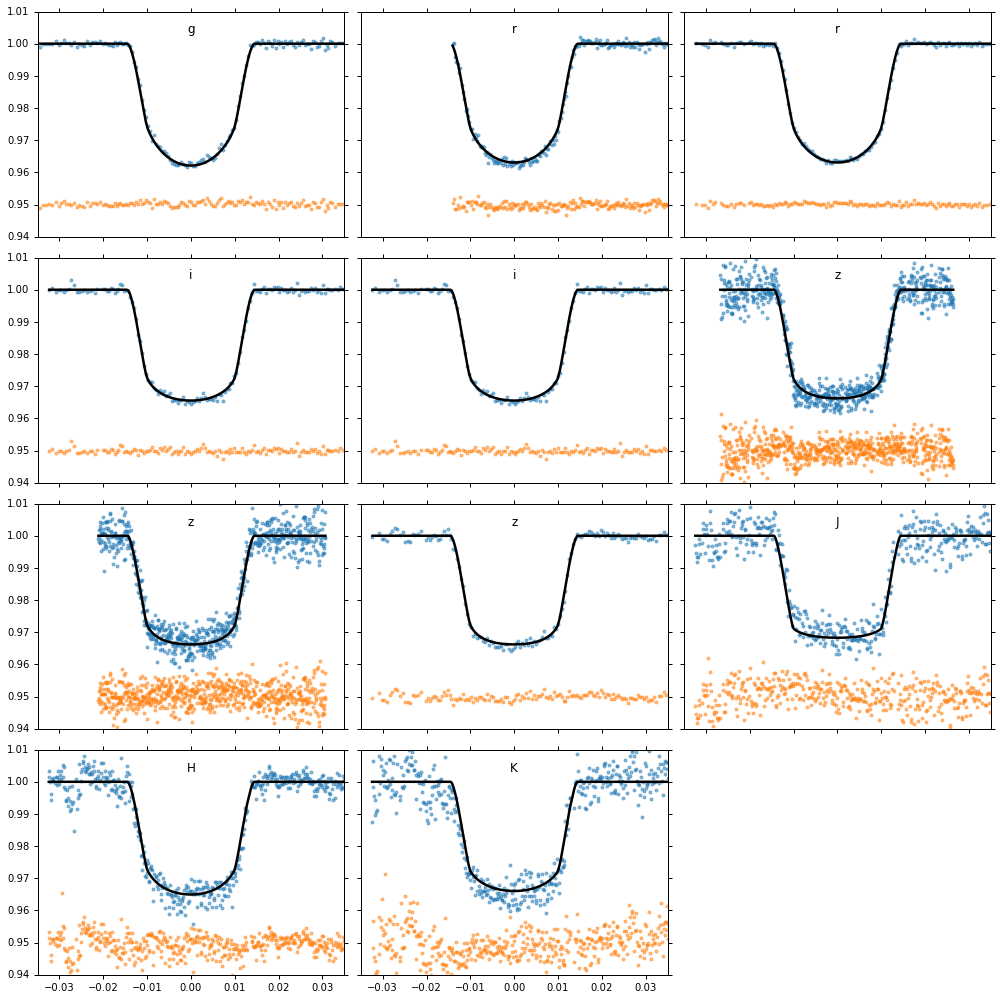

In [5]:
phases = map(lambda t: fold(t, P, TC, 0.5)-0.5, lpf.times)
fig,axs = subplots(4,3, figsize=(14,14),sharey=True, sharex=True)
for iax,ilc in enumerate(lpf.lcorder):
    a = axs.flat[iax]
    a.plot(phases[ilc],lpf.fluxes[ilc],'.', alpha=0.5)
    a.plot(phases[ilc],fluxes_m[ilc],'k')
    a.plot(phases[ilc],lpf.fluxes[ilc]-fluxes_m[ilc]+0.95,'.', alpha=0.5)
    a.text(0.5, 0.95, lpf.passbands[ilc], ha='center', va='top', size=12, transform=a.transAxes)
setp(axs, ylim=(0.94,1.01), xlim=(-0.035,0.035))
fig.tight_layout()
axs.flat[-1].set_visible(False)

In [11]:
hps = []
for i,gp in enumerate(gps):
    de = DiffEvol(gp.lnposterior, gp.ps.bounds, 30, maximize=True)
    de._population[:,0] = log10(normal(gp.flux.std(), 2e-1*gp.flux.std(), 30))
    de._population[:,2] = log10(normal(gp.flux.std(), 2e-1*gp.flux.std(), 30))
    de.optimize(25)
    hps.append(gp.fit(de.minimum_location, False))
    clear_output(wait=True)
    display(HTML('{:d} / {:d}'.format(i+1, len(gps))))

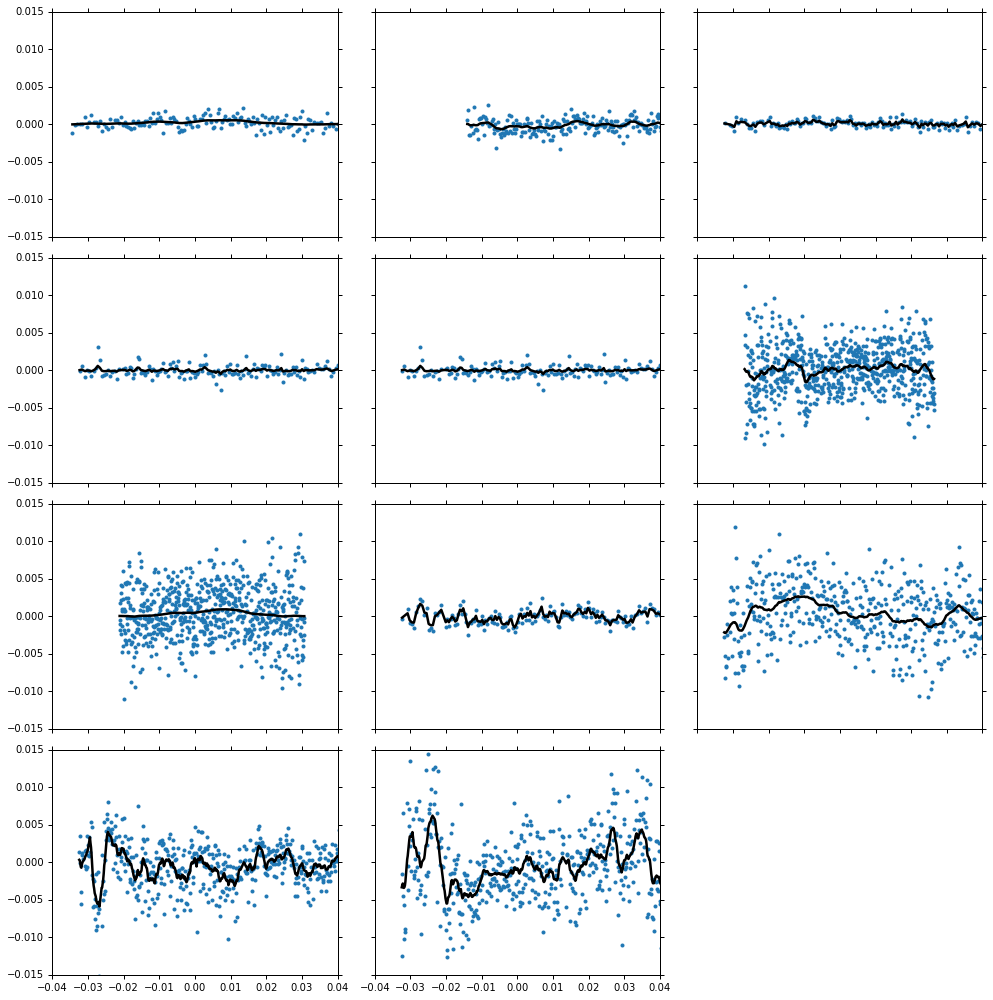

In [12]:
fig,axs = subplots(4,3, figsize=(14,14),sharey=True, sharex=True)
for iax,ilc in enumerate(lpf.lcorder):
    axs.flat[iax].plot(phases[ilc],gps[ilc].flux,'.', alpha=1)
    gps[ilc].compute(hps[ilc])
    pr = gps[ilc].predict(hps[ilc])
    axs.flat[iax].plot(phases[ilc], pr, 'k')
setp(axs, ylim=(-0.015,.015), xlim=(-0.04,0.04))
fig.tight_layout()
axs.flat[-1].set_visible(False)

In [53]:
f = pd.HDFStore('data/external_lcs.h5')
ntr = [k[3:] for k in f.keys() if 'lc/triaud' in k]
nma = [k[3:] for k in f.keys() if 'lc/mancini' in k]
f.close()

df = pd.DataFrame(hps, columns=gp.names, index=lpf.passbands)
df['lc_name'] = ntr+nma

df

,log10_amplitude,inverse_time_scale,log10_white_noise,lc_name
r,-3.394733,14047.150270,-3.053293,/triaud2013/r/eulercam_1
z,-3.058914,58371.475034,-2.505422,/triaud2013/z/trappist_1
z,-3.284828,619.437477,-2.459441,/triaud2013/z/trappist_2
H,-2.722326,42655.227377,-2.604163,/mancini2014/H/grond
J,-2.822566,3468.858786,-2.444267,/mancini2014/J/grond
K,-2.547458,17541.845902,-2.378594,/mancini2014/K/grond
g,-3.495219,500.000000,-3.130402,/mancini2014/g/grond
i,-3.499528,499999.999998,-3.164170,/mancini2014/i/dfosc
i,-3.500000,499999.999998,-3.163923,/mancini2014/i/grond
r,-3.499967,499999.999999,-3.452475,/mancini2014/r/grond


In [58]:
df.ix[:3].to_hdf(result_file, 'gphp/triaud2013')
df.ix[3:].to_hdf(result_file, 'gphp/mancini2014')